## Download the weights from the link below , if you need to just test the model



*   [First_model_weights](https://mega.nz/#!BkpyQabD!rKqr3s0ltLbMrDb9STBHc9uQik-bWpKmiUjuzrPOFXY)
*   [Second_model_weights](https://mega.nz/#!0ooQ0YgD!SHLDPCN-qtycWrESlYhqxwmllWlS7mN3xq3IFwRLiyA)
* [Third_model_weights](https://mega.nz/#!5loSFaBC!8JX-WuD2M4PfxX7OKvRcd8nRNsv6pZGDRe3yYwAmivc)

#### Note:
Some fine tuning is required to achieve the final accuracy obtained in the competition



## Load all the necessary libraries

The dependencies to run this code are:



*   [Numpy](https://pypi.org/project/numpy/)      
*   [Pandas](https://pypi.org/project/pandas/)
*   [Pretrainedmodels](https://pypi.org/project/pretrainedmodels/)
*   [PyTorch](https://pytorch.org/)
*   [Fastai](https://www.fast.ai/)






In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [0]:
!pip install pretrainedmodels

In [0]:
from torchvision.models import *
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta
import fastai
import sys
import torch
fastai.__version__

'1.0.57'

In [0]:
lis = os.listdir('link_to_the_train_folder_of_dataset')
bs=8
path = "link_to_the_train_folder_of_dataset"
## test filenames to be used to create final submission.
filenames = os.listdir('link_to_the_test_folder_of_dataset')
df = pd.read_csv('link_to_the_train_csv_of_dataset')

In [0]:
df.head() ## check the dataframe head

,image_id,category
0,0,77
1,1,81
2,2,52
3,3,72
4,4,58


## Transformations applied to the image in the dataset

Special thanks to [@Gurvinder Singh](https://www.hackerearth.com/@gurvinder3) for the baseline as I joined the competition in later stages ( 5 days prior to deadline )

In [0]:
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0,do_flip=False,xtra_tfms=[cutout()])
tfms1 = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0,do_flip=False,xtra_tfms=[cutout()])
data = (ImageList.from_csv(path, csv_name = 'path_to_train_csv', suffix='.jpg')
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = 'path_to_test_folder_dataset')              
        .transform(tfms, size=400)
        .databunch(num_workers=8,bs=8))

data1 = (ImageList.from_csv(path, csv_name = 'path_to_train_csv', suffix='.jpg')
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = 'path_to_test_folder_dataset')              
        .transform(tfms1, size=400)
        .databunch(num_workers=8,bs=8))

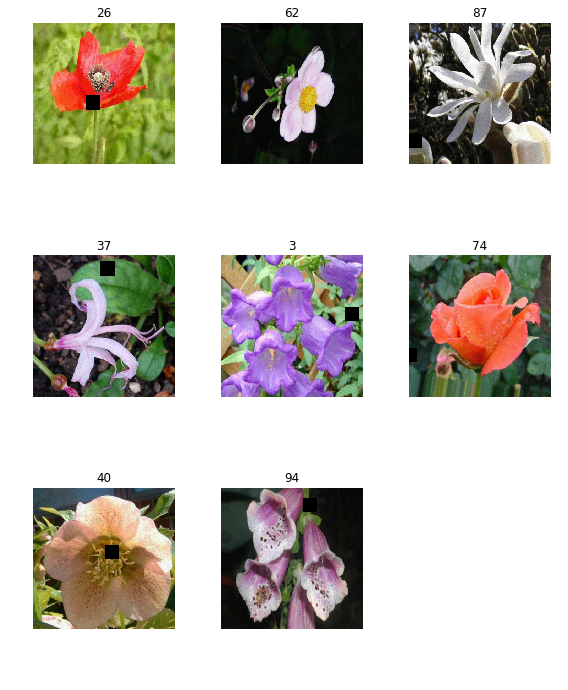

In [0]:
## Visualize the dataset

data.show_batch(rows=3, figsize=(8,10))


## The architecture used for classification

The final model was ensemble of two popular architectures,namely:

1.   [DenseNet](https://arxiv.org/abs/1608.06993)
2.   [ResNet](http://www.arxiv.org/abs/1512.03385)

Three specific varients of these popular architecture were used as a part of an ensemble model

1.   DenseNet-169
2. ResNet-152
3.DenseNet-161

Pretrained models were obtained from the library pretrainedmodels and transfer learning was used for classification putpose






epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.111402,0.051866,0.006472,0.993528,22:58


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


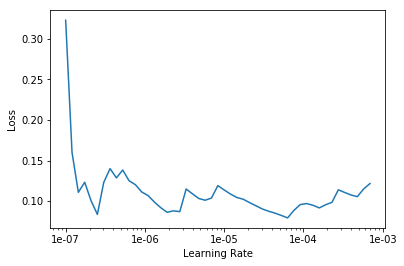

In [0]:
##If only testing is to be done, just run these cells and ignore the previous cells
learn = cnn_learner(data, models.densenet169, metrics=[error_rate, accuracy]).load("path_to_model.pth")

In [0]:
##load if weights are saved
learn2 = cnn_learner(data1, models.resnet152, metrics=[error_rate, accuracy]).load("path_to_model02.pth")


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:04<00:00, 57771441.09it/s]


'\nlearn2.fit_one_cycle(1)\nlearn2.unfreeze()\nlearn2.lr_find()\nlearn2.fit_one_cycle(2, max_lr=slice(1e-9,1e-6))\nlearn2.save("/content/drive/My Drive/model02")\n'

In [0]:
##load if weights are saved
learn3 = cnn_learner(data, models.densenet161, metrics=[error_rate, accuracy]).load("path_to_the_saved_model05.pth")

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:04<00:00, 27586750.42it/s]


## Use the learned model to do predictions on the test dataset

Note that the testing is done iin batch_size=8,please change it to relevent size by changing  **bs** parameter above.



In [0]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)
preds2,_ = learn2.TTA(ds_type=DatasetType.Test)
preds3,_ = learn3.TTA(ds_type=DatasetType.Test)

## preprocessing to save the CSV files

Second model contributes more to true positive in validation dataset. The numbers chosen here were obtained through trial and error.



1.   To save dataset in submission format , we will have to strip the *.jpg* at the end of each label


2.   We will have to sort the *image_id* in increasing order.

Finally the CSV is saved in submission.csv





In [0]:
labelled_preds = []
pred11 = 0.85*preds2 + 0.1*preds+ 0.05*preds3
for pred in pred11:
    labelled_preds.append(int(np.argmax(pred))+1)

submission = pd.DataFrame(
    {'image_id': filenames,
     'category': labelled_preds,
    })
submission['image_id'] = submission['image_id'].apply(lambda x:x.split('.')[0])
submission = submission.sort_values(by = ['image_id'], ascending = [True])
submission.to_csv('path_to_save_submission.csv',index=False)